# Bond Option Pricing using Black-Karasinski Model

Value an option on a coupon paying bond using the Black-Karasinski model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
from financepy.finutils import *
from financepy.market.curves import *
from financepy.products.funding import *
from financepy.models import *
from financepy.products.bonds import *

####################################################################
# FINANCEPY BETA Version 0.185 - This build:  24 Oct 2020 at 20:12 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
# For info and disclaimer - https://github.com/domokane/FinancePy  #
#      Send any bug reports or comments to quant@financepy.com     #
####################################################################



## Bond Option Valuation

In [6]:
valuationDate = FinDate(1, 12, 2019)
settlementDate = valuationDate

Set up discount curve

In [7]:
dcType = FinDayCountTypes.THIRTY_360_BOND
fixedFreq = FinFrequencyTypes.SEMI_ANNUAL
swapType = FinSwapTypes.PAY
swap1 = FinIborSwap(settlementDate,"1Y",swapType,0.0500,fixedFreq,dcType)
swap2 = FinIborSwap(settlementDate,"3Y",swapType,0.0500,fixedFreq,dcType)
swap3 = FinIborSwap(settlementDate,"5Y",swapType,0.0500,fixedFreq,dcType)
swap4 = FinIborSwap(settlementDate,"7Y",swapType,0.0500,fixedFreq,dcType)
swap5 = FinIborSwap(settlementDate,"10Y",swapType,0.0500,fixedFreq,dcType)
swaps = [swap1, swap2, swap3, swap4, swap5]

liborCurve = FinIborSingleCurve(valuationDate, [], [], swaps)

## Set up the Bond Option

First create the bond

In [8]:
issueDate = FinDate(1, 12, 2015)
maturityDate = FinDate(1, 12, 2029)
coupon = 0.05
freqType = FinFrequencyTypes.SEMI_ANNUAL
accrualType = FinDayCountTypes.THIRTY_360_BOND
bond = FinBond(issueDate, maturityDate, coupon, freqType, accrualType)

Let's first price the bond on the libor curve

In [9]:
price = bond.cleanPriceFromDiscountCurve(settlementDate, liborCurve)
print("Fixed Income Price:", price)

Fixed Income Price: 99.99993325529165


Then define and create the option

In [10]:
expiryDate = settlementDate.addTenor("18m")
strikePrice = 90.0
face = 100.0
optionType = FinBondOptionTypes.AMERICAN_CALL

### Black Karasinski Model

Set the model parameters

In [11]:
sigma = 0.20
a = 0.05
bkModel = FinModelRatesBK(sigma, a)

In [12]:
strikes = [80, 85, 90, 95, 100, 105, 110, 115, 120]

In [13]:
for K in strikes:
    europeanCallBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.EUROPEAN_CALL)
    v_ec = europeanCallBondOption.value(settlementDate, liborCurve, bkModel)
    americanCallBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.AMERICAN_CALL)
    v_ac = americanCallBondOption.value(settlementDate, liborCurve, bkModel)
    europeanPutBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.EUROPEAN_PUT)
    v_ep = europeanPutBondOption.value(settlementDate, liborCurve, bkModel)
    americanPutBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.AMERICAN_PUT)
    v_ap = americanPutBondOption.value(settlementDate, liborCurve, bkModel)
    
    print("K: %9.5f EUR_CALL: %9.5f  AMER_CALL: %9.5f  EUR_PUT: %9.5f  AMER_PUT: %9.5f" %(K, v_ec, v_ac, v_ep, v_ap))

K:  80.00000 EUR_CALL:  18.58186  AMER_CALL:  19.99993  EUR_PUT:   0.01044  AMER_PUT:   0.01108
K:  85.00000 EUR_CALL:  13.98654  AMER_CALL:  14.99993  EUR_PUT:   0.05815  AMER_PUT:   0.06159
K:  90.00000 EUR_CALL:   9.52510  AMER_CALL:  10.17627  EUR_PUT:   0.23973  AMER_PUT:   0.25978
K:  95.00000 EUR_CALL:   5.54391  AMER_CALL:   5.91886  EUR_PUT:   0.90158  AMER_PUT:   0.97440
K: 100.00000 EUR_CALL:   2.44433  AMER_CALL:   2.63697  EUR_PUT:   2.44503  AMER_PUT:   2.65227
K: 105.00000 EUR_CALL:   0.73748  AMER_CALL:   0.79732  EUR_PUT:   5.38120  AMER_PUT:   5.80733
K: 110.00000 EUR_CALL:   0.11536  AMER_CALL:   0.12509  EUR_PUT:   9.40211  AMER_PUT:  10.12526
K: 115.00000 EUR_CALL:   0.00675  AMER_CALL:   0.00724  EUR_PUT:  13.93654  AMER_PUT:  15.00007
K: 120.00000 EUR_CALL:   0.00006  AMER_CALL:   0.00006  EUR_PUT:  18.57287  AMER_PUT:  20.00007


## Convergence Testing - Black-Karasinski

It is important that the tree price is stable to the number of tree steps. This can be a challenge when pricing American optionality on bonds due to the payment of coupons and the effect of accrued interest on the clean bond price.

In [20]:
discountCurve = FinDiscountCurveFlat(valuationDate, 0.05)

In [21]:
issueDate = FinDate(1, 9, 2004)
maturityDate = FinDate(1, 9, 2025)
coupon = 0.05
freqType = FinFrequencyTypes.ANNUAL
accrualType = FinDayCountTypes.ACT_ACT_ICMA
bond = FinBond(issueDate, maturityDate, coupon, freqType, accrualType)
expiryDate = settlementDate.addTenor("18m")
face = 100.0

In [30]:
numStepsVector = range(50, 500, 10)

In [31]:
sigma = 0.00001
a = 0.05

In [32]:
K = 102.0

In [33]:
vec_ec = []
vec_ac = []
vec_ep = []
vec_ap = []

for numSteps in numStepsVector:
    
    bkModel = FinModelRatesBK(sigma, a, numSteps)
    
    europeanCallBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.EUROPEAN_CALL)
    v_ec = europeanCallBondOption.value(settlementDate, discountCurve, bkModel)

    americanCallBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.AMERICAN_CALL)
    v_ac = americanCallBondOption.value(settlementDate, discountCurve, bkModel)
    
    europeanPutBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.EUROPEAN_PUT)
    v_ep = europeanPutBondOption.value(settlementDate, discountCurve, bkModel)
    
    americanPutBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.AMERICAN_PUT)
    v_ap = americanPutBondOption.value(settlementDate, discountCurve, bkModel)
    
    # print("%d %9.5f %9.5f %9.5f %9.5f"%(numSteps, v_ec, v_ac, v_ep, v_ap))
    vec_ec.append(v_ec)
    vec_ac.append(v_ac)
    vec_ep.append(v_ep)
    vec_ap.append(v_ap)

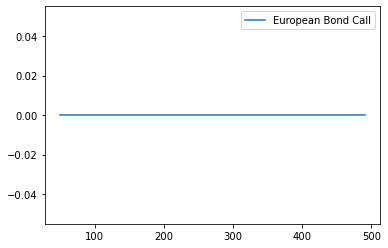

In [34]:
plt.plot(numStepsVector,vec_ec, label="European Bond Call")
plt.legend();

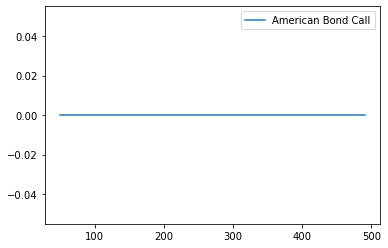

In [35]:
plt.plot(numStepsVector,vec_ac, label="American Bond Call")
plt.legend();

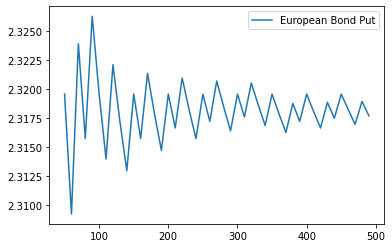

In [36]:
plt.plot(numStepsVector,vec_ep, label="European Bond Put")
plt.legend();

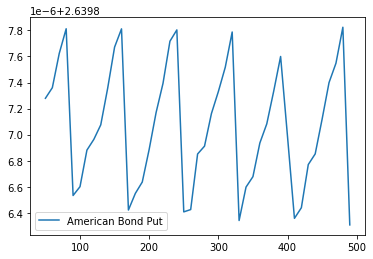

In [37]:
plt.plot(numStepsVector,vec_ap, label="American Bond Put")
plt.legend();

Copyright (c) 2020 Dominic O'Kane